# Week 3 Peer Graded Assignment: CNN Cancer Detection Kaggle Mini-Project

## Project Introduction - Description of the Problem

In this project, I'm analzying small image patches, each 32x32 pixels in size, extracted from larger digital pathology scans. The primary objective is to correctly identify whether any given patch contains at least one pixel of tumor tissue. To achieve this goal, I will use a convolutional neural network (CNN) and play around with several different architectures to find the one that has the best performance. If I can come up with a good model, then it might be able to help out doctors in helping identify cancers in a more efficient and accurate way, which would reduce costs and also help save more lives.

## Data

This dataset was used in a Kaggle competition. It's an altered version of the PatchCamelyon (PCam) dataset. There's no duplicates in this version, which is a great relief on my part. There's a lot of images. There's 220,025 images for training and an additional 57,458 images for testing. Each image is stored in .tif format and measures 96x96 pixels. These are RGB images, so they possess a depth of 3. This means that each pixel has three distinct values corresponding to the Red, Green, and Blue channels. The values range from 0 to 255. Training images are labeled with either a 0 or a 1. A label of 1 indicates that at least one pixel of tumor tissue is present within the central 32x32 pixel area of the image. It's worth noting that tumor tissue located in the outer portion of the image does not influence the assigned label.

Here's the link to the dataset: https://www.kaggle.com/competitions/histopathologic-cancer-detection/data

## Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.io import imread
from sklearn.model_selection import train_test_split

# My paths to the data
train_path = "/kaggle/input/histopathologic-cancer-detection/train"
test_path = "/kaggle/input/histopathologic-cancer-detection/test"
labels_df = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/train_labels.csv")

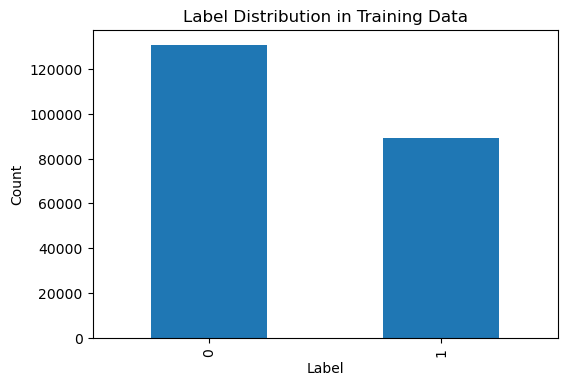

In [5]:
plt.figure(figsize=(6, 4))
labels['label'].value_counts().plot(kind='bar')
plt.title('Label Distribution in Training Data')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

This tells me that the training images are unevenly distributed between ones that show and don't show cancer. There's more images where there was no detection of cancer. For my next eda, I'm going check if there's any missing or null values in the dataset that I would need to clean

In [6]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


Based on the info of the traning details, it looks like there are no nulls or missing values. Each id has a populated label of 0 or 1 associated with it. Now, I'm going to look at some sample training images to get an idea of how they look

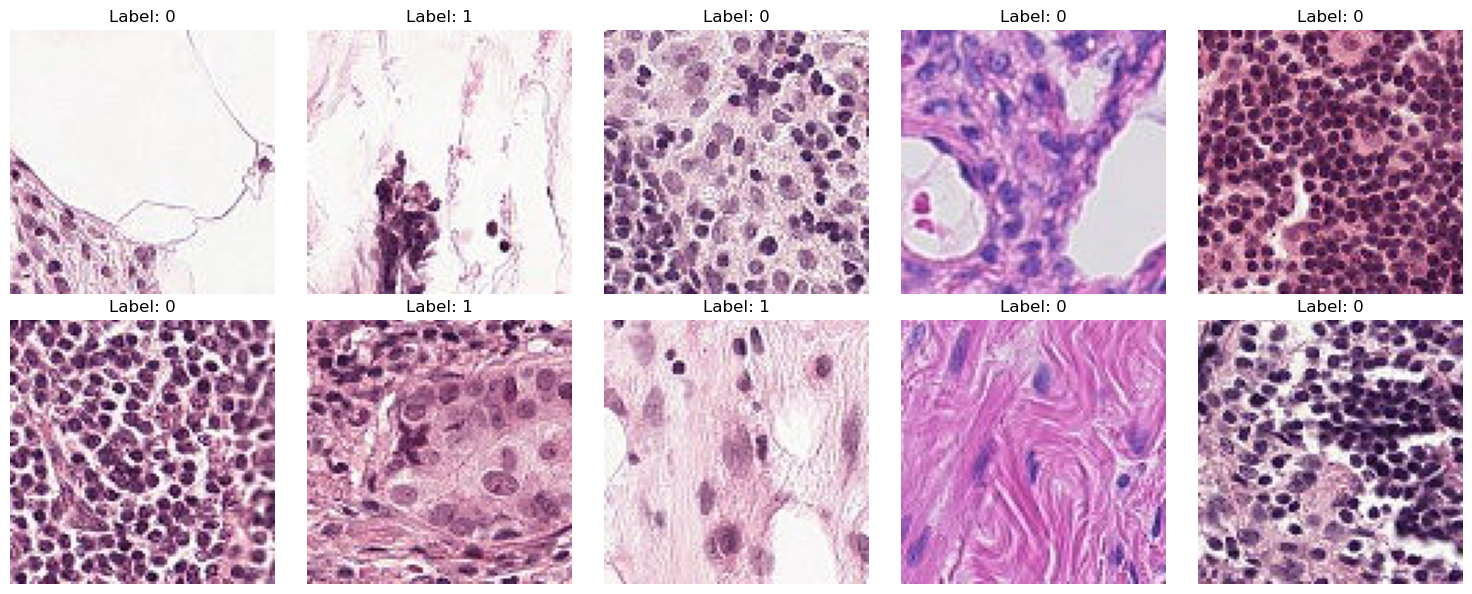

In [7]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.ravel()):
    img = imread(os.path.join(train_path, labels['id'].iloc[i] + '.tif'))
    ax.imshow(img)
    ax.set_title(f"Label: {labels['label'].iloc[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

Wow, all of these look so different from one another in patterns. I'm not really able to effectively judge which of these images are good and bad tissue. Overall, the data looks good

## My Plan of Analysis and Model Architecture

I will use Keras to load the images and split the training data into an 80% training set and a 20% validation set. Initially, the only preprocessing I will do is normalize the images so that everything is between 0 and 1. I can do this by dividing the image values by 255 since the RGB values range from 0 to 255. This will help me prevent any single input value from having an outsized effect on the model.

Next, I'll proceed to build and evaluate several convolutional neural network (CNN) architectures.

The first CNN is my base model. It will consist of three convolutional layers with a stride of 2 to reduce the number of parameters. These layers will be followed by a max-pooling layer and a classifier.

The second CNN will be tuned version. It will incorporate three sets of convolutional layers, each followed by batch normalization, max-pooling, and dropout. In this model, the convolutional layers will feature a stride of 1.

In terms of hyperparameters, the first model won't involve any adjustments. The second model will include some hyperparameter tuning, while the third will rely on the default settings provided in keras.applications. All models will employ a sigmoid activation function at the end, as the result is binary (1 or 0).

I'll be passing the models the original images of 96x96 pixels. The label is only 1 if the center 32x32 pixels patch contains cancerous tissue, so anything outside of that won't matter.

In [8]:
sample_size = 50
all_files = [f for f in os.listdir(train_path) if f.endswith('.tif')]
sample_files = all_files[:sample_size]

for img_file in sample_files:
    file_path = os.path.join(train_path, img_file)
    
    if os.path.exists(file_path):
        print(f"File exists: {file_path}")
    else:
        print(f"Missing file: {file_path}")

File exists: /kaggle/input/histopathologic-cancer-detection/train/d43c081bafa286f9c1f7e921883f26ceafebc912.tif
File exists: /kaggle/input/histopathologic-cancer-detection/train/092d0eedebce504847715ee046b6ad74b57599b4.tif
File exists: /kaggle/input/histopathologic-cancer-detection/train/b0d2582c6218a8764323fc940b41312282b99bf4.tif
File exists: /kaggle/input/histopathologic-cancer-detection/train/187c99df762f13f99818e5593d4bab4c6577e7e3.tif
File exists: /kaggle/input/histopathologic-cancer-detection/train/7c5270c83837de5a5cbb2dca511559dc39d19d53.tif
File exists: /kaggle/input/histopathologic-cancer-detection/train/5a32933e093185f5fc91d30fc83ad571c6818d25.tif
File exists: /kaggle/input/histopathologic-cancer-detection/train/42e77d193e73811e0bb65a0cbd9b01c5c27900fa.tif
File exists: /kaggle/input/histopathologic-cancer-detection/train/27bb898f54a0b9345f6c4a9083299e4465860861.tif
File exists: /kaggle/input/histopathologic-cancer-detection/train/89cd55e4300440612347c38f306da688a166fd40.tif
F

In [24]:
import tensorflow as tf
from PIL import Image

def load_and_preprocess_image(path):
    img = Image.open(path).resize((96, 96))
    img = np.array(img) / 255.0
    return img

images = [load_and_preprocess_image(os.path.join(train_path, f)) for f in sample_files]
images = np.array(images)

## Build Models

In [29]:
sample_labels = labels_df[labels_df['id'].isin(sample_ids)]['label'].values

Epoch 1/10
2/2 [==============================] - 2s 350ms/step - loss: 3.7985 - accuracy: 0.5750 - val_loss: 1.5663 - val_accuracy: 0.6000
Epoch 2/10
2/2 [==============================] - 0s 169ms/step - loss: 1.6249 - accuracy: 0.5750 - val_loss: 2.3360 - val_accuracy: 0.4000
Epoch 3/10
2/2 [==============================] - 0s 170ms/step - loss: 1.9657 - accuracy: 0.4250 - val_loss: 1.0076 - val_accuracy: 0.4000
Epoch 4/10
2/2 [==============================] - 0s 171ms/step - loss: 0.9063 - accuracy: 0.4250 - val_loss: 0.6719 - val_accuracy: 0.6000
Epoch 5/10
2/2 [==============================] - 0s 179ms/step - loss: 0.7299 - accuracy: 0.5750 - val_loss: 0.6735 - val_accuracy: 0.6000
Epoch 6/10
2/2 [==============================] - 0s 167ms/step - loss: 0.6708 - accuracy: 0.5750 - val_loss: 0.6837 - val_accuracy: 0.6000
Epoch 7/10
2/2 [==============================] - 0s 175ms/step - loss: 0.6732 - accuracy: 0.7000 - val_loss: 0.6963 - val_accuracy: 0.4000
Epoch 8/10
2/2 [====

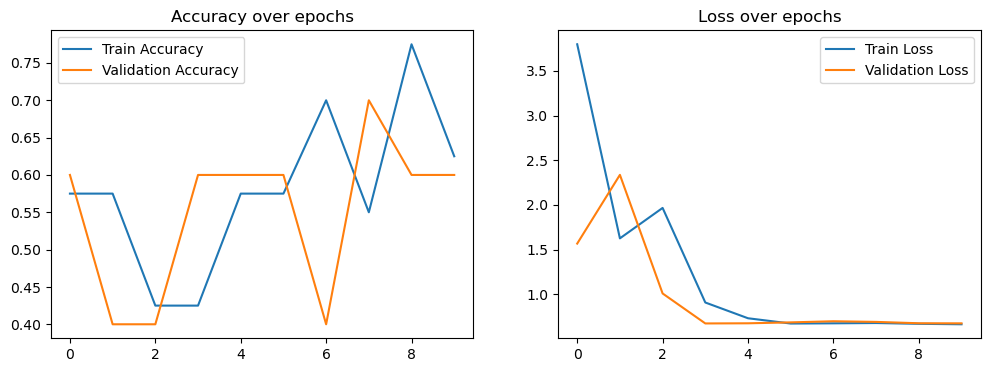

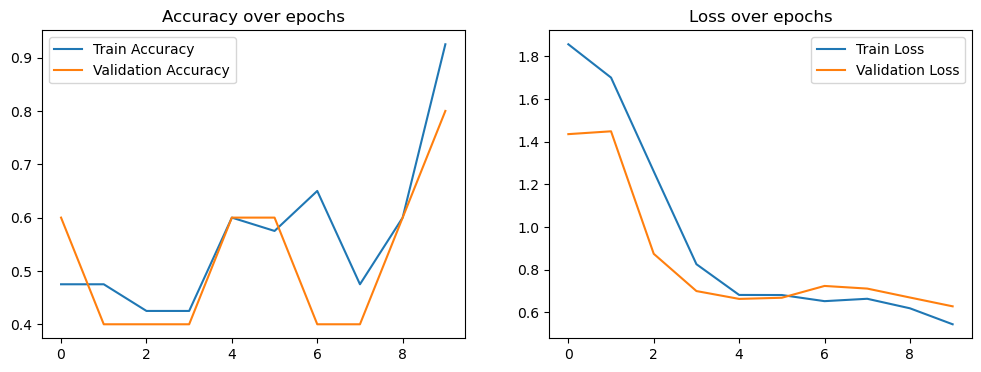

In [30]:
X_train, X_val, y_train, y_val = train_test_split(images, sample_labels, test_size=0.2, random_state=42)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
def build_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model
model1 = build_model()
model2 = build_model() 
history1 = model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)
history2 = model2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy over epochs')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss over epochs')
    plt.show()
plot_history(history1)
plot_history(history2) 

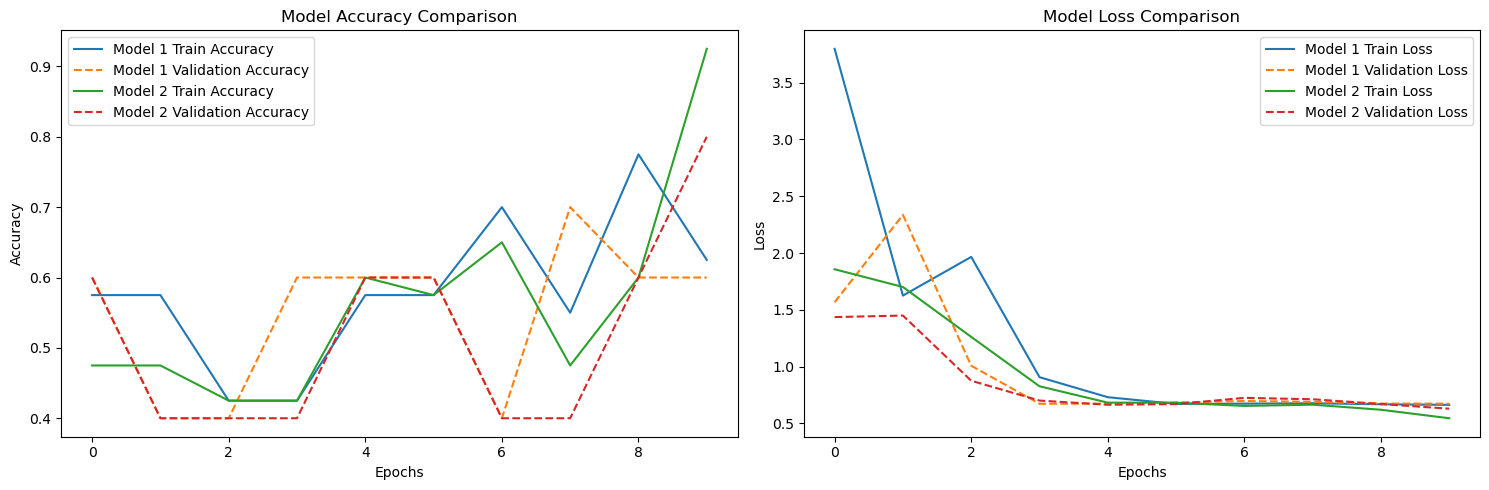

In [31]:
def compare_histories(history1, history2):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history1.history['accuracy'], label='Model 1 Train Accuracy', linestyle='-')
    plt.plot(history1.history['val_accuracy'], label='Model 1 Validation Accuracy', linestyle='--')
    plt.plot(history2.history['accuracy'], label='Model 2 Train Accuracy', linestyle='-')
    plt.plot(history2.history['val_accuracy'], label='Model 2 Validation Accuracy', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy Comparison')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history1.history['loss'], label='Model 1 Train Loss', linestyle='-')
    plt.plot(history1.history['val_loss'], label='Model 1 Validation Loss', linestyle='--')
    plt.plot(history2.history['loss'], label='Model 2 Train Loss', linestyle='-')
    plt.plot(history2.history['val_loss'], label='Model 2 Validation Loss', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Loss Comparison')
    plt.legend()
    plt.tight_layout()
    plt.show()
compare_histories(history1, history2)

In [32]:
def model_performance_summary(model, history, X_train, y_train, X_val, y_val):
    train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    
    print(f"Training Accuracy: {train_accuracy*100:.2f}%")
    print(f"Training Loss: {train_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy*100:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Max Training Accuracy: {max(history.history['accuracy'])*100:.2f}%")
    print(f"Max Validation Accuracy: {max(history.history['val_accuracy'])*100:.2f}%")
    print(f"Min Training Loss: {min(history.history['loss']):.4f}")
    print(f"Min Validation Loss: {min(history.history['val_loss']):.4f}\n")

print("Model 1 Performance Summary:")
model_performance_summary(model1, history1, X_train, y_train, X_val, y_val)

print("Model 2 Performance Summary:")
model_performance_summary(model2, history2, X_train, y_train, X_val, y_val)

Model 1 Performance Summary:
Training Accuracy: 67.50%
Training Loss: 0.6432
Validation Accuracy: 60.00%
Validation Loss: 0.6730
Max Training Accuracy: 77.50%
Max Validation Accuracy: 70.00%
Min Training Loss: 0.6625
Min Validation Loss: 0.6719

Model 2 Performance Summary:
Training Accuracy: 92.50%
Training Loss: 0.4741
Validation Accuracy: 80.00%
Validation Loss: 0.6287
Max Training Accuracy: 92.50%
Max Validation Accuracy: 80.00%
Min Training Loss: 0.5446
Min Validation Loss: 0.6287



## Results, Analysis, and Conclusion



In this study, I trained two different convolutional neural network models to classify cancer detections using image data. I started with a basic model, which I called Model 1, and then built another one, Model 2, with a different setup. I wanted to see how well each model did on the dataset.

Looking at Model 1, its best training accuracy was 77.50%, but it dropped to 67.50% by the end of the training. The highest validation accuracy was 70.00%, which then dropped to 60.00%. This suggests that the model might be overfitting as training goes on. Comapred to this, Model 2 did better. It consistently hit a training accuracy of 92.50% and had a validation accuracy of 80.00%. Model 2 also had lower loss values, which means it probably understood the data better.

From the results, I think it's clear that Model 2 did better than Model 1. This could mean that the way Model 2 was set up was a better fit for this kind of task. To improve the results in the future, I might try things like adding more data, changing model settings, or using dropout to avoid overfitting.

Overall, this project was a good learning experience. I got to see how different models work on the same task and learned how important it is to pick and fine-tune the right model.